# NLP Lab5 - Text classification

**Author: Bartłomiej Jamiołkowski**

The task concentrates on classification of sentence pairs.

This type of classification is useful for problems such as determining the similarity of sentences or checking if a text passage contains an answer to a question.

In [1]:
from datasets import load_dataset, Dataset, DatasetDict
from elasticsearch import Elasticsearch, helpers
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, TextClassificationPipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import evaluate
import math
import json

import warnings
warnings.filterwarnings('ignore')

## Task 1

Use the FIQA-PL dataset that was used in lab 1 **and** lab 2 (so we need the passages, the questions and their relations).

In [2]:
fiqa_pl_df = load_dataset('clarin-knext/fiqa-pl', 'corpus')['corpus'].to_pandas()

In [3]:
fiqa_pl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57638 entries, 0 to 57637
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   _id     57638 non-null  object
 1   title   57638 non-null  object
 2   text    57638 non-null  object
dtypes: object(3)
memory usage: 1.3+ MB


In [4]:
fiqa_pl_df['_id'] = fiqa_pl_df['_id'].apply(lambda id: int(id))
fiqa_pl_df.head()

,_id,title,text
0,3,,"Nie mówię, że nie podoba mi się też pomysł szk..."
1,31,,Tak więc nic nie zapobiega fałszywym ocenom po...
2,56,,Nigdy nie możesz korzystać z FSA dla indywidua...
3,59,,Samsung stworzył LCD i inne technologie płaski...
4,63,,Oto wymagania SEC: Federalne przepisy dotycząc...


In [5]:
fiqa_pl_queries_df = load_dataset('clarin-knext/fiqa-pl', 'queries')['queries'].to_pandas()

In [6]:
fiqa_pl_queries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6648 entries, 0 to 6647
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   _id     6648 non-null   object
 1   title   6648 non-null   object
 2   text    6648 non-null   object
dtypes: object(3)
memory usage: 155.9+ KB


In [7]:
fiqa_pl_queries_df['_id'] = fiqa_pl_queries_df['_id'].apply(lambda id: int(id))
fiqa_pl_queries_df.head()

,_id,title,text
0,0,,Co jest uważane za wydatek służbowy w podróży ...
1,4,,Wydatki służbowe - ubezpieczenie samochodu pod...
2,5,,Rozpoczęcie nowego biznesu online
3,6,,„Dzień roboczy” i „termin płatności” rachunków
4,7,,Nowy właściciel firmy – Jak działają podatki d...


In [8]:
fiqa_pl_train_df = load_dataset('clarin-knext/fiqa-pl-qrels', 'default')['train'].to_pandas()
fiqa_pl_validation_df = load_dataset('clarin-knext/fiqa-pl-qrels', 'default')['validation'].to_pandas()
fiqa_pl_test_df = load_dataset('clarin-knext/fiqa-pl-qrels', 'default')['test'].to_pandas()

fiqa_pl_relations_df = pd.concat([fiqa_pl_train_df, fiqa_pl_validation_df, fiqa_pl_test_df])

In [9]:
fiqa_pl_relations_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17110 entries, 0 to 1705
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   query-id   17110 non-null  int64
 1   corpus-id  17110 non-null  int64
 2   score      17110 non-null  int64
dtypes: int64(3)
memory usage: 534.7 KB


In [10]:
fiqa_pl_relations_df.head()

,query-id,corpus-id,score
0,0,18850,1
1,4,196463,1
2,5,69306,1
3,6,560251,1
4,6,188530,1


## Task 2

Create a dataset of positive and negative sentence pairs.
- In each pair the first element is a question and the second element is a passage, i.e. "{question} {separator} {passage}", where `separator` should be a separator taken from the model's tokenizer.
- Use the relations to mark the positive pairs (i.e. pairs where the question is answered by the passage).
- Use your own strategy to mark negative pairs (i.e. you can draw the negative examples, but there are better strategies to define the negative examples). The number of negative examples should be larger than the number of positive examples.

I decided to create a dataset using FTS and Elasticsearch. By doing this, I intend to select incorrect answers that are as similar as possible to the correct ones.

In [13]:
es = Elasticsearch(
    'https://host.docker.internal:9200',
    verify_certs = False,
    basic_auth = ('elastic', 'X9dVZZhr53SgmKtVumrn'))

print(es.info())

{'name': 'db5b00ccdaa3', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'SjT3xS9LRKOClcBPPMzEfw', 'version': {'number': '8.16.1', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': 'ffe992aa682c1968b5df375b5095b3a21f122bf3', 'build_date': '2024-11-19T16:00:31.793213192Z', 'build_snapshot': False, 'lucene_version': '9.12.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'}


In [14]:
index_configuration = {
    'settings': {
        'analysis': {
            'analyzer': {
                'polish_analyzer_lemmatization': {
                    'type': 'custom',
                    'tokenizer': 'standard',
                    'filter': [
                        'lowercase',
                        'morfologik_stem',
                        'lowercase'
                    ]
                },
            }
        }
    },
    'mappings': {
        'properties': {
            'text_with_lemmatization': {
                'type': 'text',
                'analyzer': 'polish_analyzer_lemmatization'
            }
        }
    }
}

In [15]:
es.indices.delete(index = 'fiqa_pl_index')

ObjectApiResponse({'acknowledged': True})

In [16]:
#es.indices.delete(index = 'fiqa_pl_index')
es.indices.create(index = 'fiqa_pl_index', body = index_configuration)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'fiqa_pl_index'})

In [17]:
fiqa_pl_text_list = fiqa_pl_df.to_dict('records')

In [18]:
def index_textual_data(iterable_data):
    iterable_actions = [
    {'_op_type': 'index',
     '_index': 'fiqa_pl_index',
     '_source': {
        'text_with_lemmatization': element['text'],
        'title': element['title'],
        'id': element['_id']
        }
    }
    for element in iterable_data]

    return iterable_actions

helpers.bulk(es, index_textual_data(fiqa_pl_text_list))

(57638, [])

In [20]:
def search_k_answers_ids(es, query, k):
    body_query = {
        'query': {
            'match': {
                'text_with_lemmatization': {
                    'query': query,
                    'analyzer': 'polish_analyzer_lemmatization'
                }
            }
        },
        '_source': ['id']
    }

    response = es.search(index = 'fiqa_pl_index', body = body_query)['hits']['hits'][:k]
    return [hit['_source']['id'] for hit in response]

In [21]:
def create_positive_negative_pairs(k):
    dataset_df = pd.DataFrame(columns=['_id', 'title', 'text', 'label'])
    pairs_frames = []

    for query_id in fiqa_pl_relations_df['query-id'].unique():
        query = fiqa_pl_queries_df[fiqa_pl_queries_df['_id'] == query_id]['text'].iloc[0]
        answers_ids = search_k_answers_ids(es, query, k)

        proper_answers_ids = fiqa_pl_relations_df[fiqa_pl_relations_df['query-id'] == query_id]['corpus-id'].tolist()
        negative_answers_ids = list(set(answers_ids) - set(proper_answers_ids))

        proper_answers_df = pd.merge(fiqa_pl_df, pd.DataFrame({'_id': proper_answers_ids, 'label': 1}), on = '_id', how = 'inner')
        proper_answers_df['text'] = proper_answers_df['text'].map(lambda answer: f'Query: {query} Answer: {answer}')

        negative_answers_df = pd.merge(fiqa_pl_df, pd.DataFrame({'_id': negative_answers_ids, 'label': 0}), on = '_id', how = 'inner')
        negative_answers_df['text'] = negative_answers_df['text'].map(lambda answer: f'Query: {query} Answer: {answer}')

        pairs_frames.append(pd.concat([proper_answers_df, negative_answers_df], ignore_index = True))

    dataset_df = pd.concat(pairs_frames, ignore_index = True).sample(frac = 1).drop(columns = ['_id', 'title']).reset_index(drop = True)

    return dataset_df

In [22]:
dataset_df = create_positive_negative_pairs(k = 20)

In [23]:
dataset_df.head()

,text,label
0,"Query: Jak stosunkowo łatwo wykazać, że fundus...",0
1,Query: Czy rozszerzona gwarancja Chryslera jes...,0
2,Query: Czy będę mógł kupić ziemię? Answer: „W ...,0
3,Query: Jak ryzykowne jest utrzymywanie mojego ...,0
4,Query: Planowanie emerytury: Emerytura czy osz...,0


In [24]:
dataset_df['label'].value_counts()

label
0    62816
1    17110
Name: count, dtype: int64

Values presented above prove that the number of negative examples significantly exceedes the number of positive examples.

## Task 3

The dataset from point 2 should be split into training, evaluation and testing subsets.

I decided to use a popular dataset split in the following proportions: 80% for training, 10% for validation and 10% for testing.

In [25]:
train_subset_df, test_subset_df = train_test_split(dataset_df, test_size = 0.3, random_state = 24)
validation_subset_df, test_subset_df = train_test_split(test_subset_df, test_size = 0.5, random_state = 24)

In [26]:
print(f'Training subset shape: {train_subset_df.shape}')
print(f'Validation subset shape: {validation_subset_df.shape}')
print(f'Testing subset shape: {test_subset_df.shape}')

Training subset shape: (55948, 2)
Validation subset shape: (11989, 2)
Testing subset shape: (11989, 2)


In [27]:
train_subset_df.head()

,text,label
64216,Query: Jakie są główne strategie inwestycyjne ...,0
66355,Query: Optymalny sposób wykorzystania karty kr...,1
2699,Query: Co to jest „konsolidacja” zadłużenia i ...,0
30887,Query: Potrzebujesz pomysłów na małą firmę z b...,1
11165,Query: Zrozumienie różnic między funduszami ET...,0


In [28]:
validation_subset_df.head()

,text,label
73411,Query: 4 miesiące na 30-miesięczną pożyczkę na...,0
54167,Query: Czy ceny akcji spadają z powodu dywiden...,0
71917,Query: Wczesne ćwiczenia i 83(b) Wybory Answer...,0
21515,"Query: Czym mogę zastąpić Microsoft Money, sko...",1
77971,Query: Czy ktoś porównał osobistego doradcę po...,0


In [29]:
test_subset_df.head()

,text,label
23382,Query: Posiadany dom krócej niż 2 lata - 1031 ...,0
32361,Query: Jak mogę zaoszczędzić na kosztach zamkn...,0
35825,Query: Skutki podatkowe i finansowe dzielenia ...,0
33688,Query: Dlaczego akcje wycenione na ASX powyżej...,0
56562,Query: Jak mogę znaleźć zagubione 401K od popr...,0


## Task 4 - 5

Train a text classifier using the Transformers library that distinguishes between the positive and the negative  pairs. To make the process manageable use models of size `base` and a runtime providing GPU/TPU acceleration. Consult the discussions related to fine-tuning Transformer models to select sensible set of parameter. You can also run several trainings with different hyper-parameters, if you have access to large computing resources.

Make sure you monitor the relevant metrics on the validation set during training. The last saved model might not be the  one with the best performance.

In [30]:
datasets = DatasetDict({
    'train': Dataset.from_pandas(train_subset_df, preserve_index = False),
    'validation': Dataset.from_pandas(validation_subset_df, preserve_index = False),
    'test': Dataset.from_pandas(test_subset_df, preserve_index = False)
})

In [31]:
datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 55948
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 11989
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 11989
    })
})

In [32]:
tokenizer = AutoTokenizer.from_pretrained('allegro/herbert-base-cased')
tokenized_datasets = datasets.map(lambda example: tokenizer(example['text'], truncation = True, padding = 'max_length'), batched = True)

Map:   0%|          | 0/55948 [00:00<?, ? examples/s]

Map:   0%|          | 0/11989 [00:00<?, ? examples/s]

Map:   0%|          | 0/11989 [00:00<?, ? examples/s]

In [33]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 55948
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11989
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11989
    })
})

It is wise to save all datasets in Parquet format before using Google Colab. This decision helps me avoid restarting the notebook from the beginning and wasting GPU resources, which should instead be used for model training.

In [34]:
for dataset_name in ['train', 'validation', 'test']:
    tokenized_datasets[dataset_name].to_parquet(f'data/{dataset_name}/{dataset_name}_data.parquet')

Creating parquet from Arrow format:   0%|          | 0/56 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/12 [00:00<?, ?ba/s]

In Google Colab I read previously saved data.

In [37]:
tokenized_datasets = DatasetDict()

for dataset_name in ['train', 'validation', 'test']:
    tokenized_datasets[dataset_name] = Dataset.from_parquet(f'./data/{dataset_name}/{dataset_name}_data.parquet') # ./drive/MyDrive/Lab5/data/

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Because the dataset is imbalanced, I am using the F1 score as a metric during model training. I also save checkpoints. From my prior experiences with Google Colab, I know it can turn off when the GPU limit is exceeded or when there is no user activity. To avoid losing all progress, I save checkpoints, which allow me to continue model training after such incidents.

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis = 1)
    return evaluate.load('f1').compute(predictions = predictions, references = labels)

model = AutoModelForSequenceClassification.from_pretrained('allegro/herbert-base-cased', num_labels = 2)

training_args = TrainingArguments(
    output_dir = './drive/MyDrive/Lab5/checkpoints',
    do_train = True,
    do_eval = True,
    evaluation_strategy = 'steps',
    eval_steps = 500,
    per_device_train_batch_size = 32,
    per_device_eval_batch_size = 32,
    learning_rate = 5e-05,
    warmup_ratio = 0.1,
    weight_decay = 1e-3,
    num_train_epochs = 4,
    logging_first_step = True,
    logging_strategy = 'steps',
    logging_steps = 100,
    save_strategy = 'steps',
    save_steps = 500,
    fp16 = True,
)

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_datasets['train'].shuffle(seed = 24),
    eval_dataset = tokenized_datasets['validation'].shuffle(seed = 24),
    compute_metrics = compute_metrics,
)

trainer.train()

model.save_pretrained('./drive/MyDrive/Lab5/model')

config.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allegro/herbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,F1
500,0.328300,0.358624,0.013825
1000,0.326000,0.345808,0.066517
1500,0.294300,0.291735,0.459601
2000,0.269900,0.328428,0.176450
2500,0.272700,0.259498,0.510477
3000,0.265500,0.251326,0.510106
3500,0.252100,0.237495,0.513767
4000,0.242500,0.233582,0.556754
4500,0.213700,0.239396,0.601263
5000,0.227200,0.214171,0.609528


Using a Google account with maximum free disk space was not enough to store all the saved data, resulting in the loss of information about a few of the last checkpoints. Moreover, on one account, the GPU limit was exceeded and as I predicted, everything was turned off. I had to use the last valid checkpoint (Checkpoint-9500) to continue training on another Google account.

In [15]:
trainer.train(resume_from_checkpoint = './drive/MyDrive/Lab5/checkpoints/checkpoint-9500')

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,F1
10000,0.131300,0.224788,0.667557
10500,0.147000,0.281515,0.649938
11000,0.191200,0.274620,0.591121
11500,0.195700,0.259890,0.595098
12000,0.180800,0.252655,0.595735
12500,0.182300,0.262304,0.618887


TrainOutput(global_step=12728, training_loss=0.04264065632649295, metrics={'train_runtime': 3399.8176, 'train_samples_per_second': 119.769, 'train_steps_per_second': 3.744, 'total_flos': 1.0713671685414912e+17, 'train_loss': 0.04264065632649295, 'epoch': 4.0})

Under such conditions, Checkpoint-10000 turned out to be the best option for setting the final model.

In [16]:
model = AutoModelForSequenceClassification.from_pretrained('./drive/MyDrive/Lab5/checkpoints/checkpoint-10000')
model.save_pretrained('./drive/MyDrive/Lab5/model')

In [18]:
predictions = trainer.predict(tokenized_datasets['test'])
y_pred = np.argmax(predictions.predictions, axis = -1)
y_true = predictions.label_ids

In [22]:
results_df = pd.DataFrame({
    'text': tokenized_datasets['test']['text'],
    'label': y_true,
    'label_pred': y_pred
})

results_df.head()

,text,label,label_pred
0,Query: Jak odliczyć stratę operacyjną od podat...,0,0
1,Query: Jak działają stopy procentowe i spłaty ...,0,0
2,Query: ~75 tysięcy dolarów oszczędności - spła...,0,0
3,Query: Jak zaoszczędzić na ubraniach i butach ...,1,1
4,Query: Czy osoby prowadzące działalność na wła...,0,0


## Task 6

Report the results you have obtained for the model. Use appropriate measures, since the dataset is not balanced.

In [19]:
evaluation_metrics_dict = {'accuracy': accuracy_score, 'precision': precision_score, 'recall': recall_score, 'f1': f1_score}

for metric_name, metric in evaluation_metrics_dict.items():
  print(f'{metric_name.capitalize()}: {metric(y_true, y_pred)}')

Accuracy: 0.9111121298248831
Precision: 0.625243474873393
Recall: 0.6216111541440743
F1: 0.6234220236939212


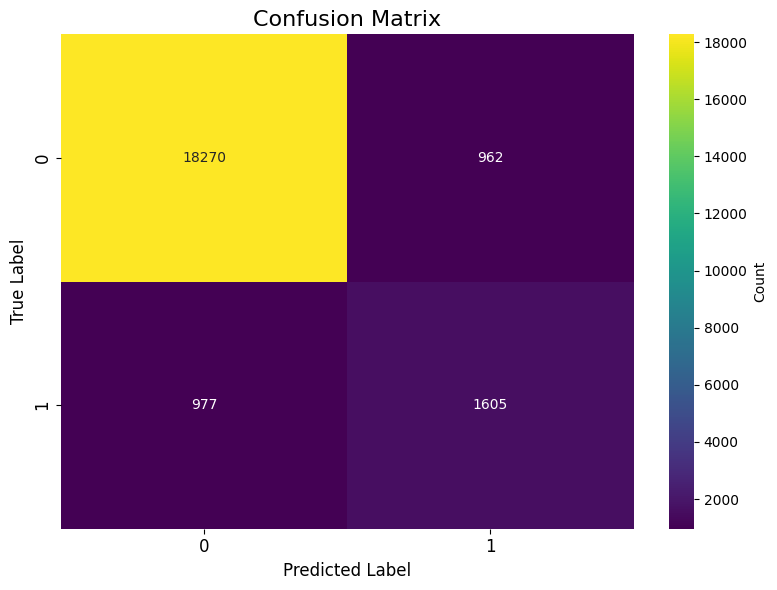

In [20]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize = (8, 6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'viridis', xticklabels = [0, 1], yticklabels = [0, 1], cbar_kws = {'label': 'Count'})
plt.title('Confusion Matrix', fontsize = 16)
plt.xlabel('Predicted Label', fontsize = 12)
plt.ylabel('True Label', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout()
plt.show()

Accuracy = 91.11% - obtained accuracy is quite good, however it should be interpreted cautiously, because of dataset's imbalance.


Precision = 62.52% - indicates that the model exhibits an moderate proportion of correct positive classifications among the predicted positives


Recall = 62.16% - indicates a relatively moderate performance in capturing true positive instances

 
F1 score = 62.34% - indicates there’s room for improvement, as it’s not very high but indicates a decent trade-off between precision and recall.

Calculated metrics indicate that the model has moderate performance and there is room for improvement.

## Task 7 - 8

Use the classifier as a re-ranker for finding the answers to the questions. Since the re-ranker is slow, you  have to limit the subset of possible passages to top-n (10, 50 or 100 - depending on your GPU) texts returned by much faster model, e.g. FTS.

The scheme for re-ranking is as follows:
- Find passage candidates using FTS, where the query is the question.
- Take top-n results returned by FTS.
- Use the model to classify all pairs, where the first sentence is the question (query) and the second sentence is the passage returned by the FTS.
- Use the score returned by the model (i.e. the probability of the **positive** outcome) to re-rank the passages.

In [38]:
model = AutoModelForSequenceClassification.from_pretrained('./checkpoints/checkpoint-10000')

In [39]:
fiqa_pl_queries_df = load_dataset('clarin-knext/fiqa-pl', 'queries')['queries'].to_pandas()

In [51]:
pipe = TextClassificationPipeline(model = model, tokenizer = tokenizer, return_all_scores = False, truncation = True, padding = 'max_length')

def search_answers_ids(es, query, k, reranking):
    body_query = {
        'query': {
            'match': {
                'text_with_lemmatization': {
                    'query': query,
                    'analyzer': 'polish_analyzer_lemmatization'
                }
            }
        },
        '_source': ['id', 'text_with_lemmatization']
    }

    response = es.search(index = 'fiqa_pl_index', body = body_query)['hits']['hits'][:k]

    if reranking:
        response = sorted(response, key = lambda doc: -float(pipe(f"Query: {query} Answer: {doc['_source']['text_with_lemmatization']}")[0]['score']))
        return [hit['_source']['id'] for hit in response]

    return [hit['_source']['id'] for hit in response]

def compute_ncdgk(answers_ids, revelant_ids, k):
    dcg = sum(1 / math.log(i + 2, 2) for i in range(k) if int(answers_ids[i]) in revelant_ids)
    idcg = sum(1 / math.log(i + 2, 2) for i in range(min(len(revelant_ids), k)))

    return dcg / idcg

def compute_analyzer_mean_ncdgn(analysed_col, k, reranking):
    ncdgk_scores = []

    for query_id in fiqa_pl_test_df['query-id'].unique():
        query = fiqa_pl_queries_df[str(query_id) == fiqa_pl_queries_df['_id']].iloc[0][analysed_col]
        answers_ids = search_answers_ids(es, query, k, reranking)
        relevant_ids = fiqa_pl_test_df[query_id == fiqa_pl_test_df['query-id']]['corpus-id'].tolist()
        ncdgk_score = compute_ncdgk(answers_ids, relevant_ids, k = k)
        ncdgk_scores.append(ncdgk_score)

    return np.mean(ncdgk_scores)

## Task 9

Compute how much the result of searching the passages improved over the results from lab 2. Use NDCG to compare the  results.

In [45]:
print(f"NDCG@10 without reranking: {compute_analyzer_mean_ncdgn('text', 10, reranking = False)}")

NDCG@10 without reranking: 0.20705719453326424


In [44]:
print(f"NDCG@10 with reranking: {compute_analyzer_mean_ncdgn('text', 10, reranking = True)}")

NDCG@10 with reranking: 0.10136132505006878


In theory, the results of searching for passages should have improved over the results from Lab 2, thanks to the application of re-ranking based on a neural network model. However, due to limited computational resources and the use of a suboptimal model, the results deteriorated, leading to lower performance in the passage search. The error caused by misclassifications from the model propagated over time, resulting in a lower NDCG@10 score.

## Questions

### Question 1
Do you think simpler methods, like Bayesian bag-of-words model, would work for sentence-pair classification? Justify  your answer.

In my opinion, simpler methods like the Bayesian bag-of-words model are generally ineffective for sentence-pair classification. By relying only on word frequencies and ignoring other aspects like: context, word order and semantic relationships, they fail to capture the nuanced connections crucial for tasks like entailment or semantic similarity. While computationally efficient, their limitations in contextual and syntactic representation lead to poorer performance compared to neural network-based models.

### Question 2
What hyper-parameters you have selected for the training? What resources (papers, tutorial) you have consulted to  select these hyper-parameters?

For training purposes, I selected parameters from a [tutorial](https://github.com/apohllo/sztuczna-inteligencja/tree/master/lab5) provided in the hints section of the laboratory description. I also referred to the official documentation to apply more useful parameters. In most cases, the parameter values were left as they were initially. However, some were adjusted based on my personal experience. The role of selected parameters is as follows:
- `output_dir`: Specifies the directory where checkpoints are saved.  
- `do_train`: Indicates whether the model should perform training.  
- `do_eval`: Indicates whether the model should perform evaluation.  
- `evaluation_strategy`: Defines the strategy for evaluating the model during training.  
- `eval_steps`: The number of steps after which the evaluation process should be run. The lower the number, the more frequently evaluations are performed. I chose 500 steps because I needed to balance having numerous checkpoints with finding the best parameter values.  
- `per_device_train_batch_size`: The batch size for training on each device. A larger batch size generally leads to faster training. I chose a value of 32 because it often appears in experiments described in scientific articles.  
- `per_device_eval_batch_size`: The batch size for evaluation on each device. It determines how many samples are evaluated simultaneously. I chose a value of 32 for the same reason as above.  
- `learning_rate`: Controls how much the model updates its weights during training. I chose 5e-05, which is a typical value for this kind of task.  
- `warmup_ratio`: The fraction of total training steps used for a warmup phase. I chose 0.1 to prevent large updates early in training.  
- `weight_decay`: A penalty applied to the model's weights during optimization to prevent overfitting.  
- `num_train_epochs`: The number of complete passes through the dataset during training.  
- `logging_first_step`: Indicates whether to log metrics during the very first training step.  
- `logging_strategy`: Specifies when to log metrics during training.  
- `logging_steps`: Specifies how often metrics like loss and accuracy are logged during training.  
- `save_strategy`: Specifies when to save model checkpoints.  
- `save_steps`: The interval (in training steps) at which checkpoints are saved.  
- `fp16`: Enables mixed precision training, reducing memory usage and speeding up training without significantly affecting model accuracy. 
rzegawczych.

### Question 3
Think about pros and cons of the neural-network models with respect to natural language processing. Provide at least  2 pros and 2 cons.

Like many tools in the universe, neural-network models have both advantages and disadvantages. These are as follows:  

**a) Advantages**:  
- Neural-network models excel at capturing the context of sentences, leading to highly promising results in natural language processing tasks.  
- They enable users without linguistic expertise to perform language modeling and train models for tasks like question classification and answering.  
- Neural networks can adapt to a variety of NLP tasks, offering flexibility and applicability to numerous domains.  

**b) Disadvantages**:  
- Training or fine-tuning neural-network models requires significant time, data, and computational resources. Even with a good GPU, these tasks can be challenging, and free platforms like Google Colab offer limited computational power, often taking hours to process large datasets. For optimal results, access to supercomputers may be necessary.  
- Neural networks often demand substantial storage, as datasets and checkpoints can occupy many gigabytes of memory.  
- These models function as black boxes, making it difficult to interpret how specific factors influence the quality of the results.  

**Summary**:  
Despite these challenges, the advantages of neural-network models outweigh their disadvantages. Their ability to perform a wide range of tasks and eliminate the need for domain-specific expertise makes them invaluable in natural language processing and beyond.  